In [1]:
import os
import re
import subprocess
import pickle
from collections import Counter
import chardet

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from nltk.corpus import stopwords
from collections import namedtuple
from sklearn.naive_bayes import GaussianNB
from nltk import NaiveBayesClassifier

from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

import gensim
import os
import collections
import smart_open
import random

from sklearn.model_selection import train_test_split

TopicProcess = namedtuple('TopicProcess', ['model', 'vectorizer', 'training_vectors'])

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Load data from all_books.pkl

In [2]:
with open('all_books.pkl', 'rb') as file: 
    all_books = pickle.load(file)

In [3]:
books = [book for book in all_books.keys()]

Labeling authors

In [4]:
def extract_all(author_list, all_books):
    books_author = []
    author_data = []
    y_author = []
    books = [book for book in all_books.keys()]
    for label, author in enumerate(author_list):
        books_author =[]
        for book in books:
            if author in book:
                books_author.append(book)
        for book in books_author:
            entries_book= all_books[book]
            for entry in entries_book:
                author_data.append(entry)
                y_author.append(label)
    return author_data, y_author

In [5]:
all_authors = ["Benito_Pérez_Galdos","Emilia_Pardo_Bazán",  "Juan_Valera", "Leopoldo_Alas_Clarín", 
               "Miguel_de_Unamuno", "Ramón_del_Valle_Inclán", "Vicente_Blasco_Ibáñez", "Pío_Baroja"]

In [6]:
all_authors_data, y_author = extract_all(all_authors, all_books)

In [7]:
len(all_authors_data)

45961

In [8]:
Counter(y_author)

Counter({0: 20566,
         1: 6765,
         2: 906,
         3: 2591,
         4: 1584,
         5: 1612,
         6: 567,
         7: 11370})

Extract some authors

In [9]:
def extract_author(all_data, y_data, label_authors):
    data_selected = []
    labels_selected = []
    for label, fragment in zip(y_data, all_data):
        if label in label_authors:
            data_selected.append(fragment)
            labels_selected.append(label)
    return data_selected, labels_selected

In [10]:
selected_data, y_selected = extract_author(all_authors_data, y_author, [0,7])
len(selected_data)

31936

### Vectorizing the data

In [11]:
stop = stopwords.words('spanish')
stop += ['.', ',', '(', ')', "'", '"', "-"]
stop = set(stop)

In [12]:
len(all_authors_data)

45961

In [13]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

incorporating vectorization and dimensionality reduction in a single function. The output is a named tuple with model vectorizer and training method.

In [14]:
def vectorization_reduction(data, stop, vec, dim_red, n_comp, ngram_min, ngram_max, max_freq): 
    count_vectorizer = CountVectorizer(ngram_range=(ngram_min, ngram_max),  
                                       stop_words=stop, 
                                       token_pattern="\\b[a-z][a-z]+\\b",
                                       lowercase=True,
                                       max_df = max_freq)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(ngram_min, ngram_max),  
                                       stop_words=stop, 
                                       token_pattern="\\b[a-z][a-z]+\\b",
                                       lowercase=True,
                                       max_df = max_freq)
    cv_data = count_vectorizer.fit_transform(data)
    tfidf_data = tfidf_vectorizer.fit_transform(data)
    if vec=="count" and dim_red=="LSA":
        lsa_cv = TruncatedSVD(n_components=n_comp)
        lsa_cv_data = lsa_cv.fit_transform(cv_data)
        return TopicProcess(model=lsa_cv, vectorizer=count_vectorizer, training_vectors=lsa_cv_data)
    if vec=="count" and dim_red=="NMF":
        nmf_cv = NMF(n_components=n_comp)
        nmf_cv_data = nmf_cv.fit_transform(cv_data)
        return TopicProcess(model=nmf_cv, vectorizer=count_vectorizer, training_vectors=nmf_cv_data)
    if vec=="tfidf" and dim_red=="LSA":
        lsa_tfidf = TruncatedSVD(n_components=n_comp)
        lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
        return TopicProcess(model=lsa_tfidf, vectorizer=tfidf_vectorizer, training_vectors=lsa_tfidf_data)

### Clustering the authors ( tfidf-LSA vectorization)  

In [15]:
process_lsa_tfidf = vectorization_reduction(all_authors_data, stop, vec="tfidf", dim_red="LSA", n_comp=30, ngram_min=1, ngram_max=3, max_freq=0.3)

##### Using Kmeans

In [16]:
def kmeans_fit(data, y_author, k_min, k_max):
    cluster_author = []
    inertias = []
    for k in range(k_min,k_max+1):
        km = KMeans(n_clusters=k)
        km.fit(data)
        labels = km.labels_
        inertias.append(km.inertia_) 
        for index in range(data.shape[0]):
            cluster_author.append(["k="+str(k), labels[index], y_author[index]])
    return cluster_author, inertias

Plotting the clusters for k=6 

In [17]:
cluster_author, inertias = kmeans_fit(process_lsa_tfidf.training_vectors, y_author, 6, 6)

In [18]:
dictio_clusters = Counter( ["Cluster:" + str(cluster) + "; Author:" + str(author) for k, cluster, author in cluster_author] )
dictio_clusters

Counter({'Cluster:0; Author:0': 41,
         'Cluster:0; Author:1': 1,
         'Cluster:0; Author:4': 36,
         'Cluster:0; Author:5': 30,
         'Cluster:0; Author:7': 1450,
         'Cluster:1; Author:0': 4368,
         'Cluster:1; Author:1': 2135,
         'Cluster:1; Author:2': 458,
         'Cluster:1; Author:3': 1355,
         'Cluster:1; Author:4': 511,
         'Cluster:1; Author:5': 150,
         'Cluster:1; Author:6': 220,
         'Cluster:1; Author:7': 320,
         'Cluster:2; Author:0': 8794,
         'Cluster:2; Author:1': 3658,
         'Cluster:2; Author:2': 308,
         'Cluster:2; Author:3': 890,
         'Cluster:2; Author:4': 813,
         'Cluster:2; Author:5': 1319,
         'Cluster:2; Author:6': 313,
         'Cluster:2; Author:7': 6926,
         'Cluster:3; Author:0': 438,
         'Cluster:3; Author:1': 10,
         'Cluster:3; Author:2': 10,
         'Cluster:3; Author:4': 5,
         'Cluster:3; Author:7': 11,
         'Cluster:4; Author:0': 2548,
  

In [19]:
list_for_graph = []
for cluster in range(6):
    list_cluster = []
    for author in range(8):
        list_cluster.append(dictio_clusters["Cluster:"+str(cluster)+"; Author:"+str(author)]/Counter(y_author)[author])
    list_for_graph.append(list_cluster)
 

In [20]:
list_for_graph[0]

[0.0019935816395993387,
 0.00014781966001478197,
 0.0,
 0.0,
 0.022727272727272728,
 0.018610421836228287,
 0.0,
 0.12752858399296393]

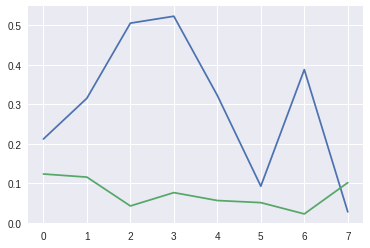

In [21]:
plt.plot(
#         range(8), list_for_graph[0], 
         range(8), list_for_graph[1], 
#         range(8), list_for_graph[2], 
#         range(8), list_for_graph[3], 
         range(8), list_for_graph[4], 
#         range(8), list_for_graph[5], 
);


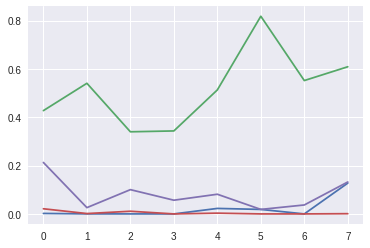

In [22]:
plt.plot(
#
    range(8), list_for_graph[0], 
#         range(8), list_for_graph[1], 
         range(8), list_for_graph[2], 
         range(8), list_for_graph[3], 
#         range(8), list_for_graph[4], 
         range(8), list_for_graph[5], 
);


Function for clustering and plotting the results.

In [23]:
def calc_n_plot(n_cluster, cluster_list=False):
    cluster_author, inertias = kmeans_fit(process_lsa_tfidf.training_vectors, y_author, n_cluster, n_cluster)
    dictio_clusters = Counter( ["Cluster:" + str(cluster) + "; Author:" + str(author) for k, cluster, author in cluster_author] )
    list_for_graph = []
    for cluster in range(n_cluster):
        list_cluster = []
        for author in range(8):
            list_cluster.append(dictio_clusters["Cluster:"+str(cluster)+"; Author:"+str(author)]/Counter(y_author)[author])
        list_for_graph.append(list_cluster)
    for cluster in range(n_cluster):
        plt.plot(range(8), list_for_graph[cluster])
    if cluster_list:
        return [[item[1], item[2]] for item in cluster_author]

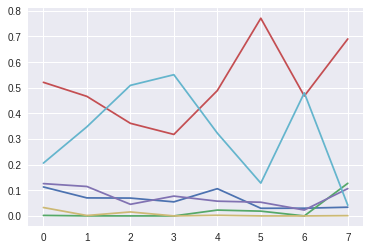

In [24]:
calc_n_plot(6)

(0, 0.2)

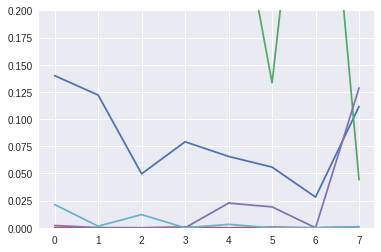

In [25]:
calc_n_plot(6)
plt.ylim(ymin=0, ymax=0.2)

(0, 0.2)

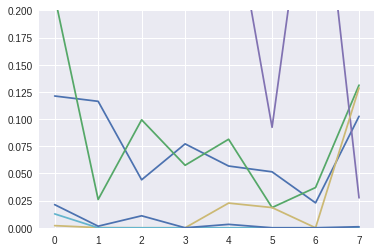

In [26]:
calc_n_plot(7)
plt.ylim(ymin=0, ymax=0.2)

(0, 0.2)

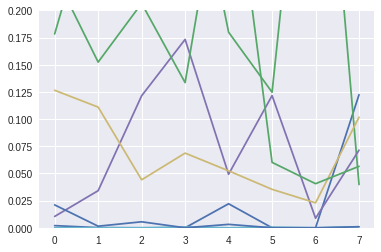

In [27]:
calc_n_plot(8)
plt.ylim(ymin=0, ymax=0.2)

(0, 0.2)

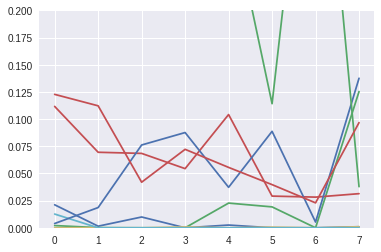

In [28]:
calc_n_plot(9)
plt.ylim(ymin=0, ymax=0.2)

(0, 0.2)

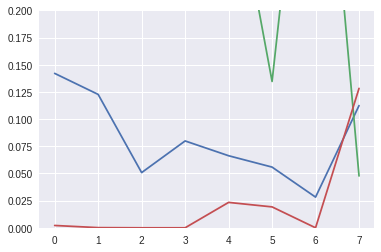

In [29]:
calc_n_plot(4)
plt.ylim(ymin=0, ymax=0.2)

###  See the different topics

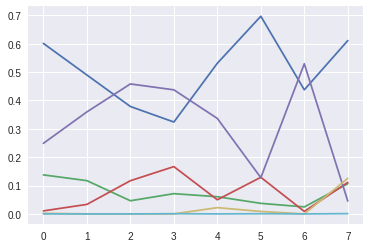

In [31]:
process_lsa_tfidf = vectorization_reduction(all_authors_data, stop, vec="tfidf", dim_red="LSA", n_comp=10, ngram_min=1, ngram_max=3, max_freq=0.3)
cluster_list_6 = calc_n_plot(6, cluster_list=True)

### Extracting topics for each cluster k-means results with k=6

In [32]:
def extract_topics(all_authors_data, cluster_list, n_cluster, topics, words, max_freq=0.1):
    fragments_cluster = [fragment for fragment, cluster in zip(all_authors_data, cluster_list) if cluster[0]==n_cluster]
    process_lsa_tfidf = vectorization_reduction(fragments_cluster, stop, vec="tfidf", dim_red="LSA", n_comp=topics, ngram_min=1, ngram_max=1, max_freq=0.1)
    display_topics(process_lsa_tfidf.model, process_lsa_tfidf.vectorizer.get_feature_names(),words)

In [33]:
topics=10 
words=20

In [34]:
extract_topics(all_authors_data, cluster_list_6, n_cluster=0, topics=topics, words=words)


Topic  0
bien, hombre, ahora, usted, tan, ver, dios, ser, mismo, hacer, parece, padre, gran, vamos, tiempo, conde, puede, mano, ojos, verdad

Topic  1
conde, dolly, nell, cura, venancio, gregoria, bien, quiero, abuelo, albrit, lucrecia, digo, abuelito, verdad, pardina, ahora, dios, quiere, escena, tan

Topic  2
conde, puerta, dolly, nell, calle, hacia, tres, pueblo, noche, hombres, cura, mar, gran, luego, sol, gente, camino, aviraneta, aquel, iba

Topic  3
hombre, bien, puede, ser, hacer, hombres, aviraneta, general, pueblo, bueno, franceses, gente, dinero, conde, cura, amigo, guerra, gobierno, gran, juan

Topic  4
hombre, dios, padre, madre, hija, quiero, pobre, mujer, ojos, juan, voz, conde, amigo, visto, vamos, ser, bueno, repuso, hijo, cabeza

Topic  5
bien, ojos, hombre, voz, madre, hija, padre, puerta, mujer, quiero, ver, tan, cara, electra, brazos, cabeza, viejo, manos, baja, mano

Topic  6
ahora, vamos, hombre, voy, ver, hacer, padre, mismo, bueno, puerta, calle, vas, quieres,

In [35]:
extract_topics(all_authors_data, cluster_list_6, n_cluster=1, topics=topics, words=words)


Topic  0
hacer, va, mismo, parece, verdad, padre, dos, vida, decir, cosa, ver, creo, tiempo, hace, voy, don, dice, vez, mal, quiero

Topic  1
lucrecia, conde, electra, pantoja, evarista, condesa, cura, alma, verdad, puedo, pausa, alcaldesa, madre, palabra, hijo, oh, vida, hija, cuesta, nunca

Topic  2
electra, pantoja, evarista, cuesta, madre, hija, vida, oh, don, salvador, perdone, pobre, malo, ay, quiero, dicho, gran, leonardo, escena, saber

Topic  3
va, aviraneta, electra, voy, hacer, lucrecia, conde, pantoja, bueno, evarista, ir, gracias, cuesta, carta, noche, entonces, calle, vaya, tilly, vamos

Topic  4
parece, verdad, creo, mal, digo, cree, aviraneta, hecho, dicho, cosa, bueno, vida, jenara, voz, entonces, cura, tilly, demasiado, gente, oswald

Topic  5
parece, quiero, voz, va, vamos, vez, esther, decir, dije, cosa, roberto, voy, mujer, mal, ver, lord, gray, susana, oswald, noche

Topic  6
padre, va, parece, ver, vamos, hija, dice, electra, cierto, don, ir, bueno, chamizo, vie

In [36]:
extract_topics(all_authors_data, cluster_list_6, n_cluster=2, topics=topics, words=words)


Topic  0
max, ana, magistral, latino, luis, eugenio, ver, vez, puerta, regenta, hacer, ahora, pues, san, siempre, noche, calle, mujer, pueblo, ojos

Topic  1
max, latino, pisa, collet, madama, lunares, claudinita, taberna, dorio, gadex, chico, maestro, muerto, poeta, zaratustra, estrella, hispalis, ministro, gay, ciego

Topic  2
urbano, evarista, electra, pantoja, cuesta, escena, patros, izquierda, balbina, leonardo, dios, derecha, mismos, foro, vaya, dorotea, salvador, entra, hoy, salen

Topic  3
empecinado, eugenio, general, san, merino, pueblo, tilly, madrid, gente, mina, hombres, diamante, chamizo, calle, guerra, miguel, cura, soldados, liberales, francisco

Topic  4
luis, pepita, conde, currito, fernando, padre, amor, vicario, san, sino, dios, lugar, hermano, pedro, genazahar, arrillaga, juanita, vargas, razones, menester

Topic  5
sergio, baronesa, mingote, paquita, puede, viejo, redondo, mejor, cogolludo, luis, hijo, padre, alonso, chucha, hija, madrid, cabeza, compungida, indi

In [37]:
extract_topics(all_authors_data, cluster_list_6, n_cluster=3, topics=topics, words=words)


Topic  0
hija, familia, quiero, pueblo, camino, madrid, san, hoy, cielo, general, paso, sabe, lado, rostro, puedo, haber, fuerza, fernando, boca, salir

Topic  1
federico, augusta, quiero, conciencia, orozco, dice, digo, puedo, quiere, hoy, sabes, creo, vivir, sabe, hija, quieres, debe, siento, ideas, ay

Topic  2
fernando, general, rey, franceses, guerra, pueblo, madrid, calpena, san, carlos, soldados, tropas, gobierno, militar, reina, jefe, espartero, palacio, camino, tropa

Topic  3
augusta, federico, orozco, quiero, ay, hija, sabes, puedo, vi, quieres, suelo, felipa, mira, brazos, dije, camino, voy, delante, cuarto, instante

Topic  4
augusta, federico, ana, orozco, magistral, conciencia, regenta, franceses, vetusta, san, general, fe, fuego, pueblo, aquello, enemigo, camino, ideas, guerra, soldados

Topic  5
ana, magistral, regenta, vetusta, fernando, madrid, hija, carta, obdulia, petra, quintanar, anita, visita, paula, familia, marquesa, pensaba, teresa, carlos, calpena

Topic  6

In [38]:
extract_topics(all_authors_data, cluster_list_6, n_cluster=4, topics=topics, words=words)


Topic  0
salvadora, baronesa, don, vamos, justa, noche, mujer, juan, cuarto, luego, ahora, hacer, tres, bueno, imprenta, mingote, vida, ver, tarde, salieron

Topic  1
baronesa, mingote, sergio, horacio, chucha, don, primo, mulata, kate, nena, hija, carta, berebere, madre, tren, darle, cogolludo, papeles, condiciones, coche

Topic  2
salvadora, juan, ignacia, imprenta, fea, baronesa, hermano, cuarto, voz, hermana, verdad, mingote, mal, chico, libertario, tarde, hecho, bien, comedor, vaya

Topic  3
justa, flora, aquella, salvadora, vida, mujer, custodio, baronesa, frase, ver, indiferencia, maten, sereno, noche, roban, calatrava, hablaron, alcoba, veces, ojos

Topic  4
vamos, salvadora, bueno, ortiz, quieres, baronesa, ahora, muchacha, calatrava, primo, libre, mingote, pues, salieron, cenar, voy, justa, bizco, garro, fea

Topic  5
imprenta, tarde, entraron, taberna, baronesa, tres, siguiente, ortiz, paseo, fea, bajaron, salieron, leandro, parador, unas, sol, salvadora, plaza, madrid, noc

In [39]:
extract_topics(all_authors_data, cluster_list_6, n_cluster=5, topics=topics, words=words)


Topic  0
hijas, acometido, pusieron, ganas, rafael, calle, bien, pellizco, cap, escritor, festivo, querer, juega, vocablo, desgracia, aunque, bajo, ustedes, usted, ruido

Topic  1
cap, pellizco, muerto, risa, triste, sacan, hombre, calle, ganas, rafael, pusieron, hijas, acometido, desgracia, juega, festivo, escritor, querer, vocablo, abonados

Topic  2
bien, juega, querer, festivo, escritor, vocablo, desgracia, hombre, triste, muerto, sacan, risa, bajo, usted, ustedes, aunque, dice, digo, convidado, concejales

Topic  3
hijas, sacan, hombre, muerto, triste, risa, acometido, ganas, pusieron, rafael, calle, aunque, bajo, saben, escribano, distingo, incomoda, marqueses, menos, entablar

Topic  4
bajo, ustedes, usted, abonados, convidado, pues, distingo, entablar, escribano, fo, gracia, incomoda, marqueses, menos, palco, pocas, zal, varonil, vengan, tocaba

Topic  5
concejales, acometido, bien, hombre, risa, triste, muerto, sacan, cap, pellizco, vocablo, juega, querer, festivo, escritor, 

In [47]:
cluster_0 = [entry[1] for entry in cluster_list_6 if entry[0]==0]
cluster_1 = [entry[1] for entry in cluster_list_6 if entry[0]==1]
cluster_2 = [entry[1] for entry in cluster_list_6 if entry[0]==2]
cluster_3 = [entry[1] for entry in cluster_list_6 if entry[0]==3]
cluster_4 = [entry[1] for entry in cluster_list_6 if entry[0]==4]
cluster_5 = [entry[1] for entry in cluster_list_6 if entry[0]==5]

In [104]:
def plot_bar_clusters(cluster, n_cluster):
    relative_abundance = []
    for index in range(8):
        relative_abundance.append(Counter(cluster)[index]/Counter(y_author)[index])
    labels = ["Galdós","Bazán","Valera", "Clarín", "Unamuno", "Valle-Inclán", "Blasco Ibáñez","Baroja"]
    y_pos = np.arange(len(labels))
    plt.figure(figsize=(15,7))
    plt.bar(labels, relative_abundance, align='center', alpha=0.5)
    plt.xticks(y_pos, labels, rotation='vertical', fontsize=25)
    plt.yticks(fontsize=25)
    plt.ylabel('Fraction of corpus', fontsize=25)
    plt.title('Cluster '+ str(n_cluster), fontsize=25)
    

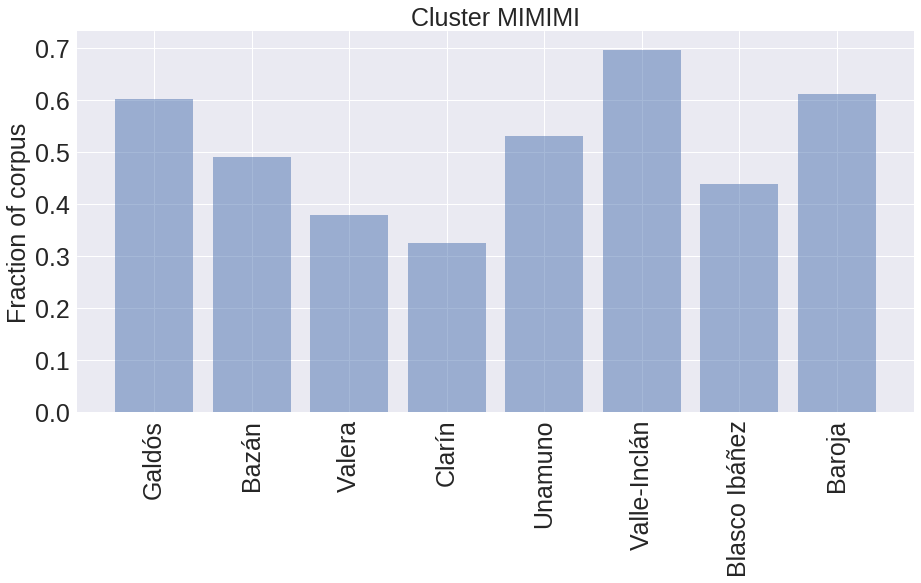

In [105]:
plot_bar_clusters(cluster_0, "MIMIMI")

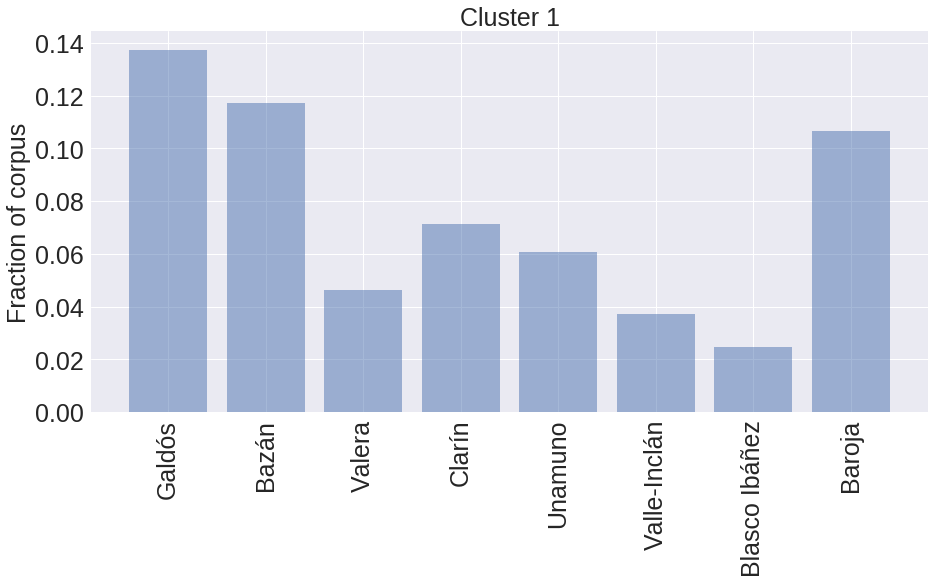

In [106]:
plot_bar_clusters(cluster_1, 1)

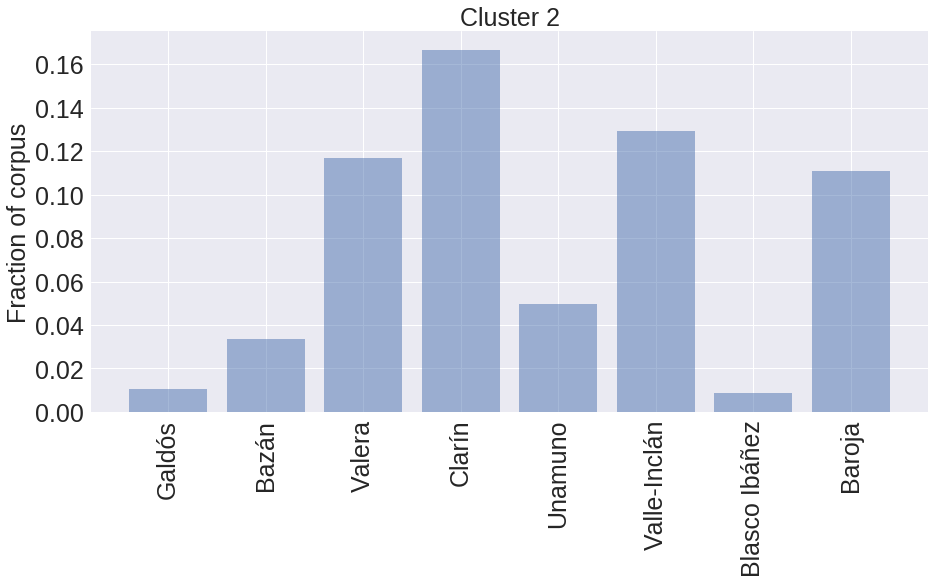

In [107]:
plot_bar_clusters(cluster_2, 2)

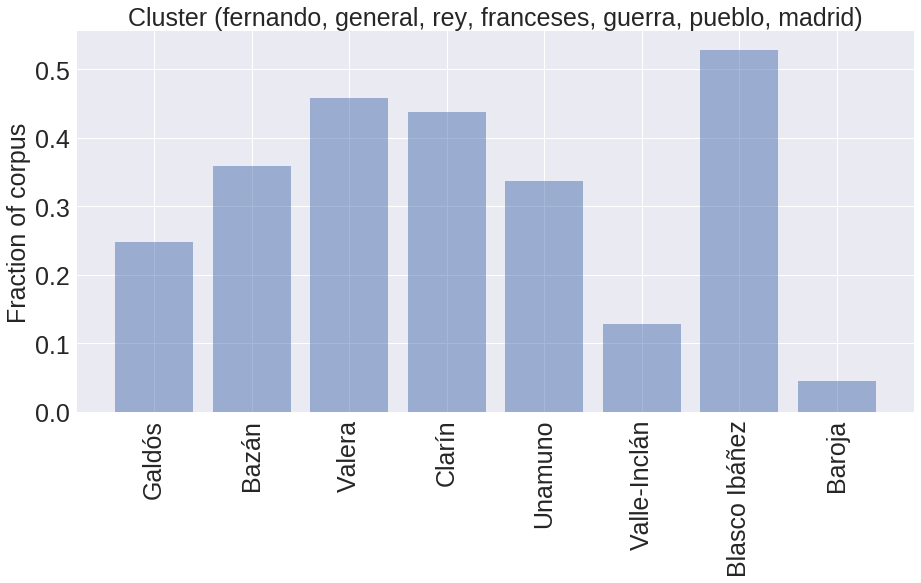

In [114]:
plot_bar_clusters(cluster_3, "(fernando, general, rey, franceses, guerra, pueblo, madrid)")

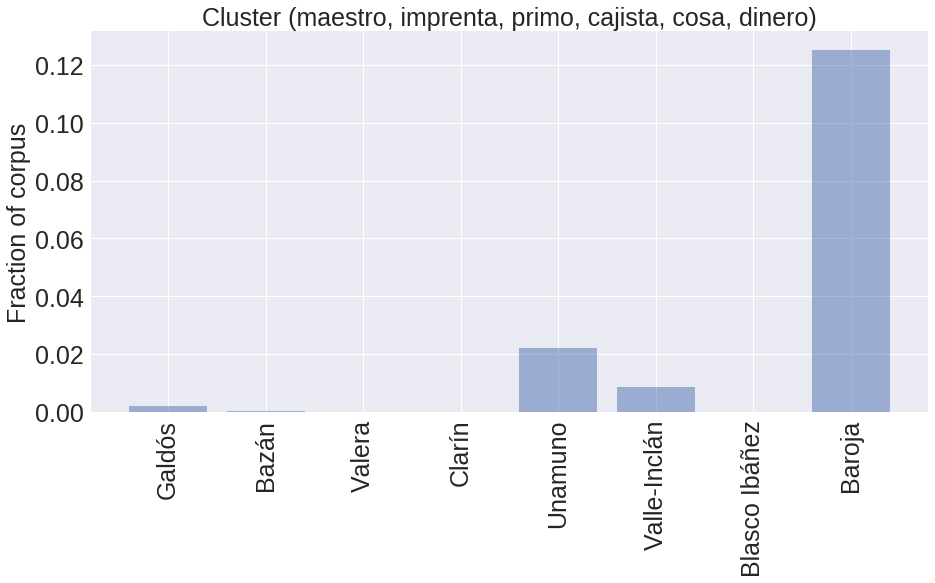

In [113]:
plot_bar_clusters(cluster_4, "(maestro, imprenta, primo, cajista, cosa, dinero)")

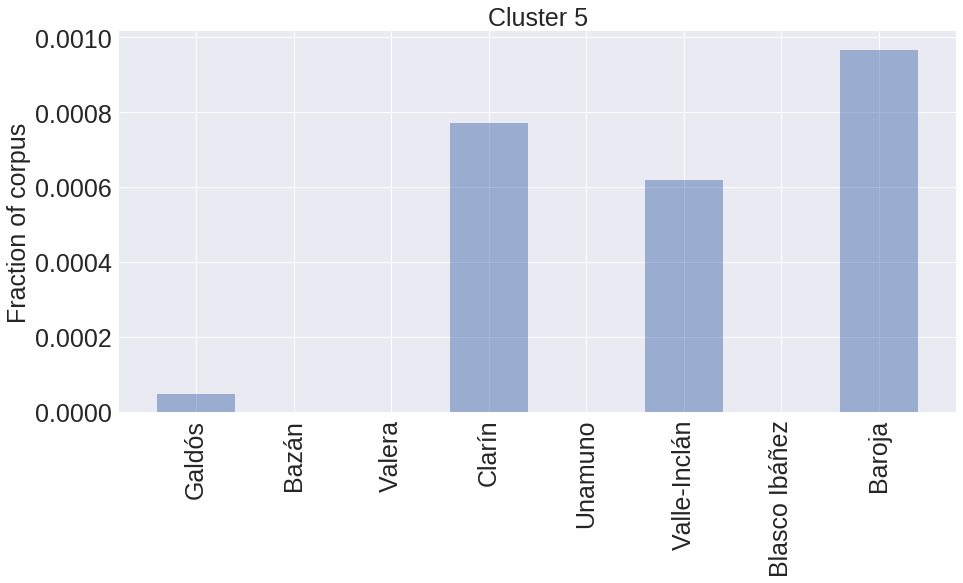

In [110]:
plot_bar_clusters(cluster_5, 5)